## Modelos multivariados
Hata el momento, se ha estudiado modelos univariados. Unicamente se trabajo con una variable endogena que esta explicada por sus rezagos. Esta seccion contara con mas de una endogena que sera explicada por sus propios rezagos, pero tambien por las otras.

Hay dos modelos multivariados conocidos:
* VAR: Vector Autorregresivo
* SVAR: Vector Autorregresivo Estructural

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.tsa.api as tsa


import warnings
warnings.simplefilter("ignore")

In [2]:
dta = pd.read_excel("./data/PeruData.xlsx", sheet_name="Trimestral", skiprows=1)
dta = dta[[
    'Trimestres', 'Producto bruto interno por tipo de gasto (millones S/ 2007) - PBI',
    'Producto bruto interno por tipo de gasto (millones S/ 2007) - Demanda Interna - Inversión Bruta Interna - Inversión Bruta Fija - Privada',
    'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)',
    'Tasas de interés del Banco Central de Reserva  - Tasa de Referencia de la Política Monetaria'
    ]]

dta.rename({
    'Producto bruto interno por tipo de gasto (millones S/ 2007) - PBI': 'PBI',
    'Producto bruto interno por tipo de gasto (millones S/ 2007) - Demanda Interna - Inversión Bruta Interna - Inversión Bruta Fija - Privada': 'Inversion_privada',
    'Índice de precios Lima Metropolitana (índice Dic.2021 = 100) - Índice de Precios al Consumidor (IPC)': 'IPC',
    'Tasas de interés del Banco Central de Reserva  - Tasa de Referencia de la Política Monetaria': 'R'
    }, axis=1, inplace=True)

dta.index = pd.period_range("1980Q1", "2022Q2", freq="Q")

dta.to_excel("./data/data_var.xlsx", index=True)
dta = pd.read_excel("./data/data_var.xlsx", index_col="Unnamed: 0").drop("Trimestres", axis=1)

In [3]:
dta

,PBI,Inversion_privada,IPC,R
1980-01-01,36357.477805,4541.789940,NaN,NaN
1980-04-01,43102.110211,5682.388255,NaN,NaN
1980-07-01,42344.482920,5320.988709,NaN,NaN
1980-10-01,45791.929063,6224.964673,NaN,NaN
1981-01-01,39025.874528,6349.408399,NaN,NaN
...,...,...,...,...
2021-04-01,136557.006532,28408.973665,95.981439,0.25
2021-07-01,140469.898532,29745.947852,98.295397,1.00
2021-10-01,146737.812314,30019.727071,100.000000,2.50
2022-01-01,132979.813881,28388.318617,101.836672,4.00


### VAR
Un modelo VAR es util para realizar proyecciones. Esta metodologia ya tiene a las variables en su forma reducida, por lo que directamente puede ser estimada por MCO siguiendo el proceso:
$$Y_t = A + B_1 Y_{t-1} + B_2 Y_{t-2} + ... + B_p Y_{t-p} + U_t$$

donde $B_i$ es una matriz $K\cdot K$ para todo $i$.

In [4]:
dta["pbi_gr"] = ((dta.PBI/dta.PBI.shift(4)) - 1) *100
dta["invpriv_gr"] = ((dta.Inversion_privada/dta.Inversion_privada.shift(4)) - 1) *100
dta["inflac"] = ((dta.IPC/dta.IPC.shift(4)) - 1) *100

dta = dta.dropna()
dta = dta[dta.index < "2020-01-01"]

dta.head()

,PBI,Inversion_privada,IPC,R,pbi_gr,invpriv_gr,inflac
2003-07-01,60551.683473,7917.067073,58.435976,2.75,3.676659,8.795529,1.976431
2003-10-01,61589.172028,7592.606488,58.892929,2.50,2.779450,1.656994,2.483754
2004-01-01,60913.815575,7995.788906,60.128103,2.50,4.574384,10.075241,2.755869
2004-04-01,67639.712867,7768.454326,60.667252,2.50,3.737932,8.780613,4.256499
2004-07-01,63145.752851,8202.150090,60.788750,2.75,4.284058,3.600867,4.026242


In [5]:
df = dta[["invpriv_gr", "pbi_gr", "inflac", "R"]]
df

,invpriv_gr,pbi_gr,inflac,R
2003-07-01,8.795529,3.676659,1.976431,2.75
2003-10-01,1.656994,2.779450,2.483754,2.50
2004-01-01,10.075241,4.574384,2.755869,2.50
2004-04-01,8.780613,3.737932,4.256499,2.50
2004-07-01,3.600867,4.284058,4.026242,2.75
...,...,...,...,...
2018-10-01,1.140884,4.651280,2.192523,2.75
2019-01-01,2.908110,2.436272,2.247441,2.75
2019-04-01,5.603677,1.169576,2.294781,2.75
2019-07-01,9.104277,3.363626,1.851007,2.50


Las series que seran usadas son las siguientes:

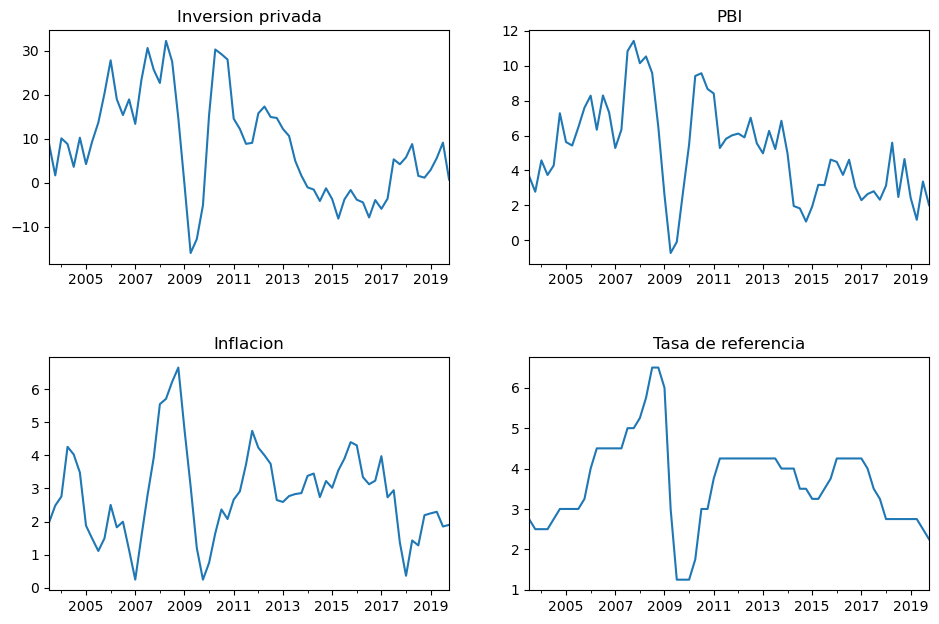

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))
labels = ["Inversion privada", "PBI", "Inflacion", "Tasa de referencia"]

for i in enumerate(df.columns):
    ax = plt.subplot(2, 2, i[0]+1)
    df[i[1]].plot()
    plt.title(labels[i[0]])
    plt.legend().remove()
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.2, right=0.75, hspace=0.4, wspace=0.2)
plt.show()

Para crear un modelo, es necesario primero saber cual es mejor modelo:

In [7]:
model_var = tsa.VAR(df)
order = model_var.select_order(maxlags=4)

order.summary()

,AIC,BIC,FPE,HQIC
0,5.501,5.638,244.8,5.555
1,1.333*,2.020*,3.799*,1.603*
2,1.338,2.573,3.842,1.823
3,1.600,3.384,5.081,2.301
4,1.597,3.930,5.232,2.513


Queda seleccionado, por todos los criterios de informacion, que la maxima cantidad de lags debe ser 1

In [8]:
model_var = tsa.VAR(df).fit(maxlags=1)
print(model_var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 25, Dec, 2022
Time:                     17:45:57
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    2.06383
Nobs:                     65.0000    HQIC:                   1.65876
Log likelihood:          -394.255    FPE:                    4.03902
AIC:                      1.39478    Det(Omega_mle):         3.00288
--------------------------------------------------------------------
Results for equation invpriv_gr
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 7.757650         2.736383            2.835           0.005
L1.invpriv_gr         0.700370         0.130657            5.360           0.000
L1.pbi_gr             0.948738         0.570692        

Al graficar las ACFs de los residuos, encontramos que no existe autocorrelacion serial

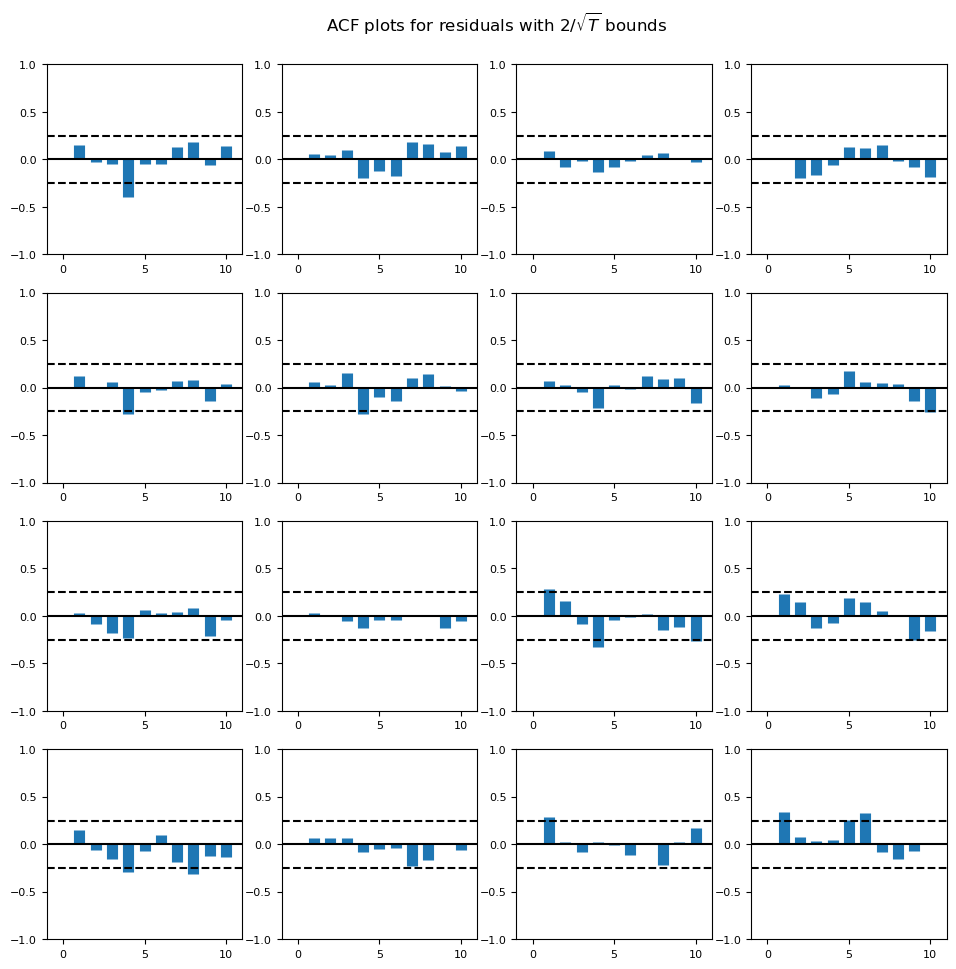

In [9]:
model_var.plot_acorr()

plt.show()

#### IRFs: Impulse Response Functions
Las funciones se estiman de la forma del $MA(\infty)$
$$Y_t = \mu + \sum_{i=0}^{\infty} \Theta_i \epsilon_{t-i}$$

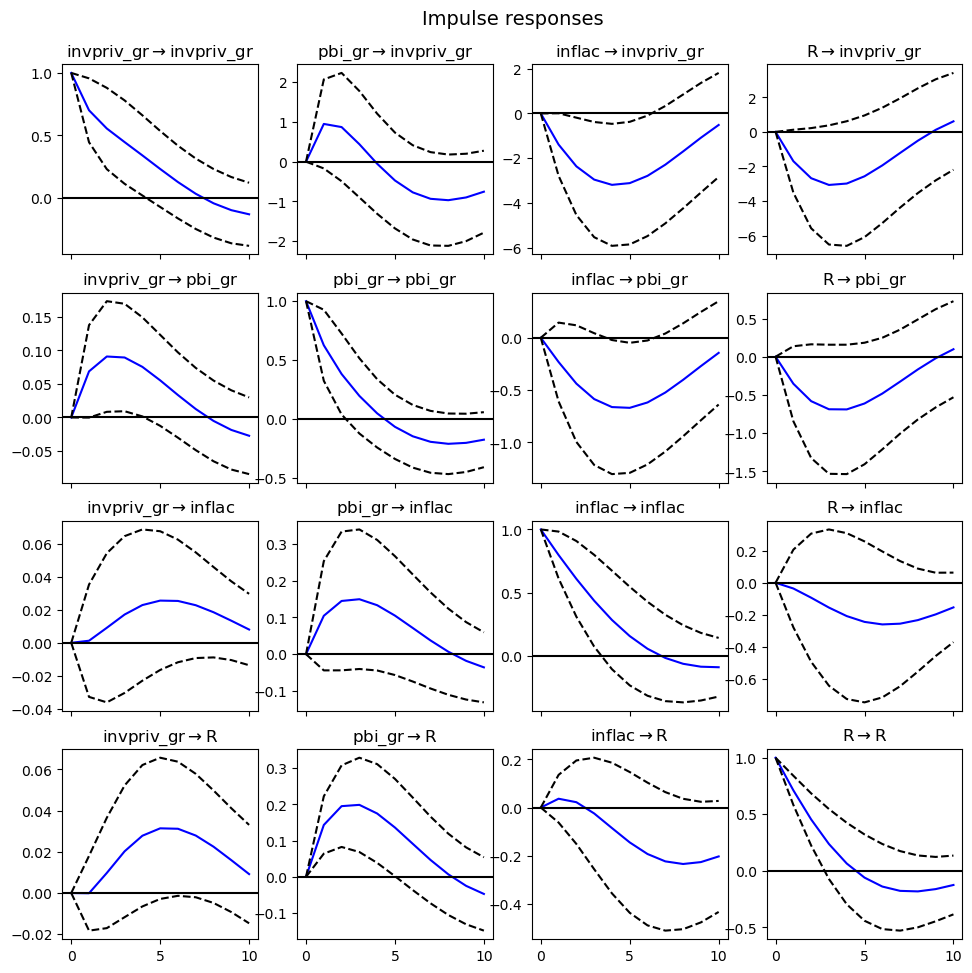

In [10]:
irfs = model_var.irf(10)

irfs.plot(orth=False)
plt.show()

Tambien se puede pedir las IRFs de solo un choque

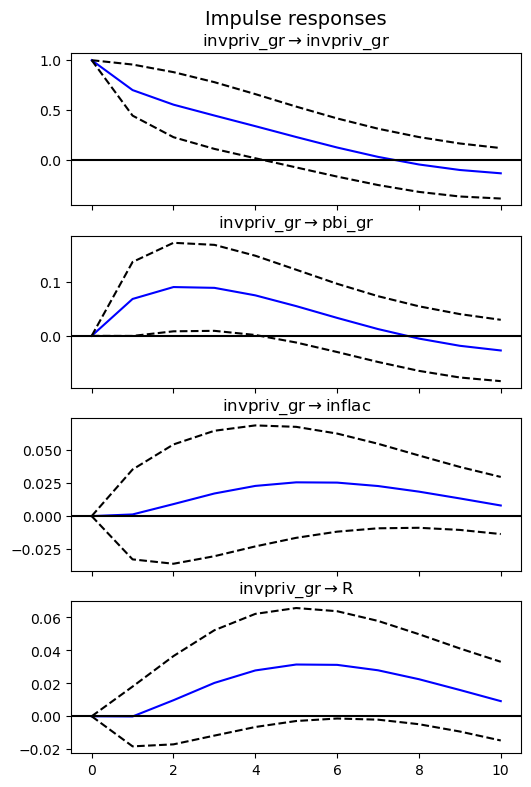

In [11]:
irfs.plot(impulse="invpriv_gr", figsize=(5, 8))

plt.show()

Las IRFs acumuladas pueden ser graficadas de la siguiente manera:

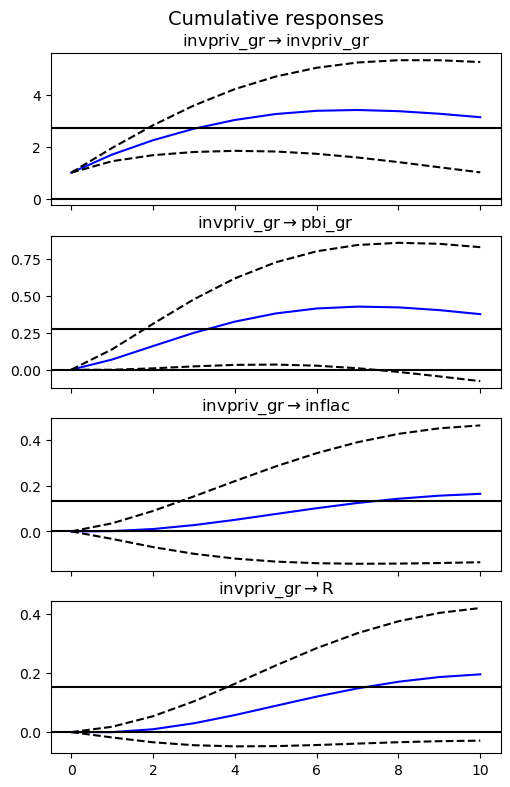

In [12]:
irfs.plot_cum_effects(orth=False, impulse="invpriv_gr", figsize=(5, 8))

plt.show()

#### FEVD: Forecast Error Variance Decomposition
La descomposicion de la varianza nos muestra como se descompone el error de proyeccion de cada variable con respecto a los choques indivuales de todas las variables. De esta manera podemos darnos una idea de la relevancia de cada una de las variables en la proyeccion de un unica variable

\begin{align}\begin{aligned}\omega_{jk, i} = \sum_{i=0}^{h-1} (e_j^\prime \Theta_i e_k)^2 / \mathrm{MSE}_j(h)\\\mathrm{MSE}_j(h) = \sum_{i=0}^{h-1} e_j^\prime \Phi_i \Sigma_u \Phi_i^\prime e_j\end{aligned}\end{align}

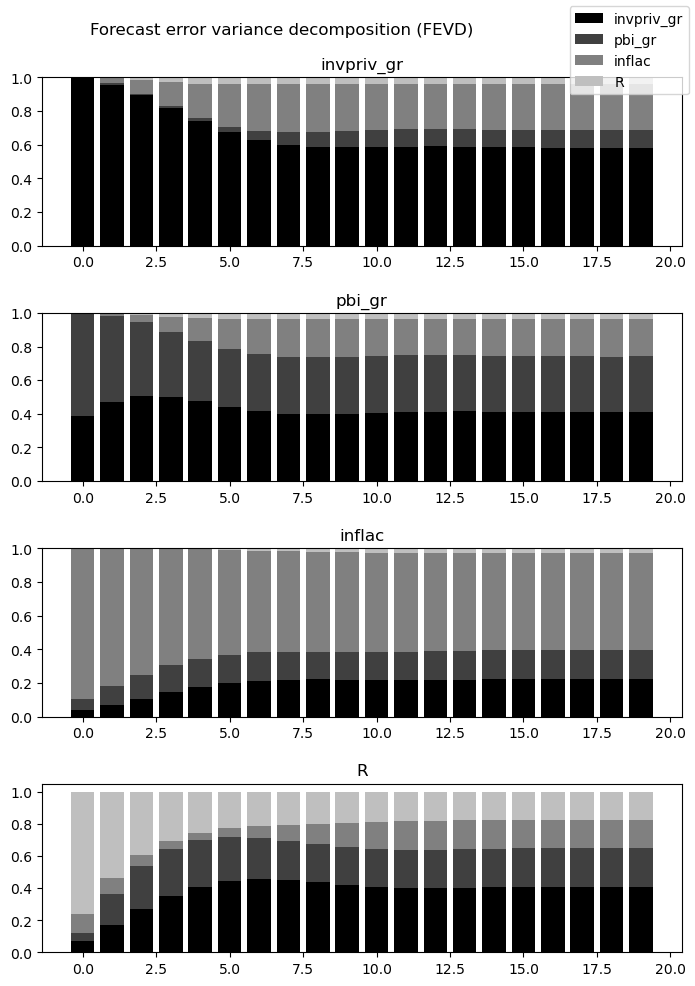

In [13]:
fevd = model_var.fevd(20)

fevd.plot(figsize=(8, 10))
plt.subplots_adjust(left=0.2, right=1, hspace=0.4, wspace=0.2)

plt.show()

#### Forecast
Finalmente, se realizara las proyecciones del modelo. Estas seran _out-sample_

In [14]:
order = model_var.k_ar

forecast_var = model_var.forecast(df.values[-order:], steps=5)
forecast_var

array([[ 3.69810908,  3.34387975,  1.80382147,  2.17072396],
       [ 7.33016208,  4.43691312,  1.87331702,  2.30215324],
       [10.59134756,  5.30820685,  2.04281044,  2.55443523],
       [13.03838918,  5.9493165 ,  2.26412958,  2.86460859],
       [14.52659531,  6.35787818,  2.49965141,  3.18496186]])

Aunque esto solo nos da el valor de la mediana. Si deseamos tambien los valores de los intervalos de confianza, se debe correr lo siguiente:

In [15]:
order = model_var.k_ar

forecast_var = model_var.forecast_interval(df.values[-order:], steps=5, alpha=0.05)
forecast_var

(array([[ 3.69810908,  3.34387975,  1.80382147,  2.17072396],
        [ 7.33016208,  4.43691312,  1.87331702,  2.30215324],
        [10.59134756,  5.30820685,  2.04281044,  2.55443523],
        [13.03838918,  5.9493165 ,  2.26412958,  2.86460859],
        [14.52659531,  6.35787818,  2.49965141,  3.18496186]]),
 array([[-7.47527993,  0.3333896 ,  0.32031249,  1.37901609],
        [-7.23377905,  0.65693295, -0.10591869,  1.14446806],
        [-6.0036806 ,  1.10850263, -0.23769893,  1.10590363],
        [-4.94430273,  1.47753799, -0.20540912,  1.19439056],
        [-4.53883317,  1.67943261, -0.08500824,  1.35482347]]),
 array([[14.8714981 ,  6.3543699 ,  3.28733045,  2.96243182],
        [21.89410321,  8.2168933 ,  3.85255273,  3.45983841],
        [27.18637573,  9.50791107,  4.32331981,  4.00296683],
        [31.02108109, 10.421095  ,  4.73366829,  4.53482661],
        [33.59202379, 11.03632374,  5.08431106,  5.01510026]]))

Donde los resultados tienen el siguiente orden: 
* Mediana
* Valor minimo
* Valor maximo

Graficamente se vera asi:

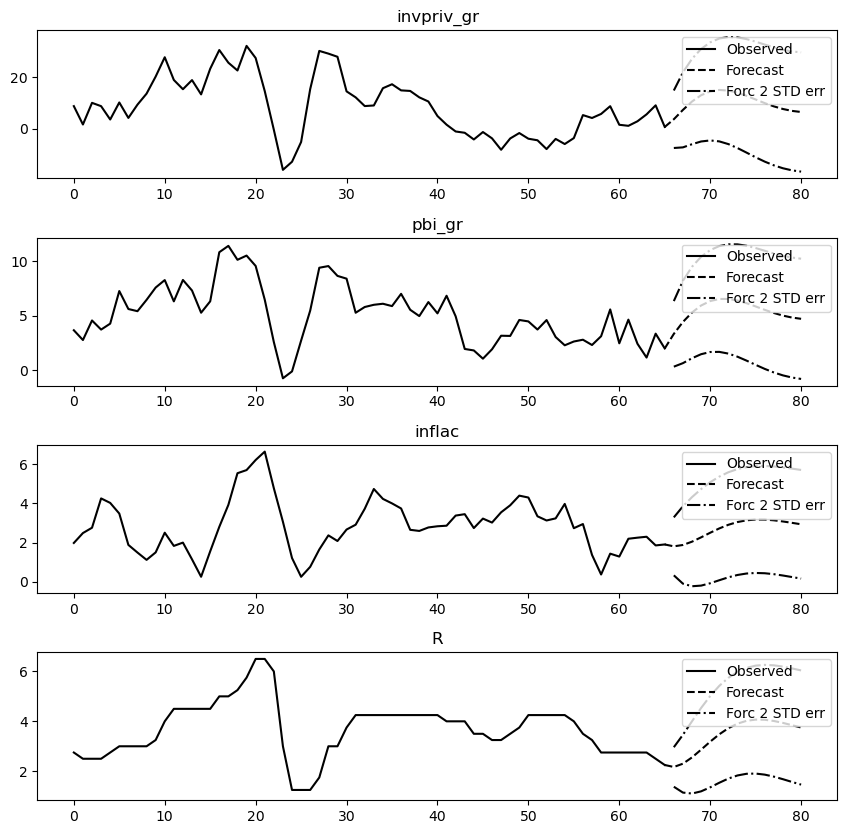

In [16]:
model_var.plot_forecast(15, alpha=0.05)

plt.subplots_adjust(left=0.2, right=1, hspace=0.4, wspace=0.2)
plt.show()

### SVAR
Un modelo SVAR es util para realizar analisis de politica. Esta metodologia no se encuentra en su forma reducida, sino en su forma estructural. Por lo tanto, es necesario realizar una identificacion al siguiente modelo:
$$AY_t = A_1 Y_{t-1} + A_2 Y_{t-2} + ... + A_p Y_{t-p} + E_t$$

donde $B_i$ es una matriz $K\cdot K$ para todo $i$. La matriz $A$ representa la matriz de efectos contemporaneos. Al estimar se debe tomar en consideracion que se realizara en su forma reducida:
$$Y_t = B_1 Y_{t-1} + B_2 Y_{t-2} + ... + B_p Y_{t-p} + U_t$$

Por lo general, la identificacion se hace mediante Cholesky.

Por el momento, por falta de literatura que me permita entender bien como trabajan las funciones de SVAR en `statsmodels`, dejo mi avance hasta este punto. Queda hacia futuro:
* Estimar el modelo SVAR y descomponer los parametros.
* Estimar IRFs, FEVD, HD para el SVAR.
* Proyectar.

#### Referencias:
* https://www.statsmodels.org/stable/vector_ar.html#var
* https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/